# AE3 — Questão 1: PINN para Barra Unidimensional (PyTorch)

**Objetivo.** Implementar uma *Physics-Informed Neural Network* (PINN) para resolver o problema 1D de uma barra tracionada com carregamento axial do tipo \( q(x) = Cx \), comparar com a solução analítica e avaliar combinações de hiperparâmetros (otimizador × taxa de aprendizado × número de épocas/passos), gerar tabela comparativa e gráficos.

**Equação (compatível com a solução informada):**
\[
\frac{d}{dx}\big(EA\,u_x\big) + Cx = 0,
\quad \text{com } u(0)=0,\quad u(L)=\frac{C L^3}{3EA}.
\]

**Solução analítica informada:**
\[
u(x) = \frac{C}{EA}\left(\frac{L^2 x}{2} - \frac{x^3}{6}\right).
\]

**Parâmetros usados:** \(EA=1\), \(L=5\) m, \(C=10\) N/m\(^2\).

**Decisões numéricas**
- **BC hard**: as condições de contorno são impostas diretamente na forma da saída, sem penalidade extra na loss;
- **Normalização**: utiliza-se \(\hat x=x/L\in[0,1]\) para estabilizar as derivadas;
- **Métrica**: erro relativo L² da solução (mais informativo do que um limiar fixo de loss).


In [12]:
!pip install torch numpy matplotlib pandas --quiet

import time
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Precisão e dispositivo
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parâmetros do problema (do enunciado)
EA_val, L_val, C_val = 1.0, 5.0, 10.0
EA = torch.tensor(EA_val, device=device)
L  = torch.tensor(L_val,  device=device)
C  = torch.tensor(C_val,  device=device)

# Condições de contorno
u_a = torch.tensor(0.0, device=device)          # u(0)
u_b = (C * L**3) / (3.0 * EA)                   # u(L)

# Solução analítica dada
def u_analytical(x):
    return (C/EA) * ((L**2) * x / 2.0 - x**3 / 6.0)

def set_seed(s=42):
    torch.manual_seed(s)
    np.random.seed(s)

set_seed(42)


## Arquitetura da rede e imposição **BC hard**

A rede aproxima a parte "livre" \(n_\theta(\hat x)\) e a solução é construída como
\[
u(x) = u_a\left(1-\frac{x}{L}\right) + u_b\left(\frac{x}{L}\right) + x(L-x)\,n_\theta(\hat x),
\quad \hat x = x/L\in[0,1].
\]
Dessa forma, \(u(0)=u_a\) e \(u(L)=u_b\) são satisfeitas exatamente.


In [13]:
class MLPn(nn.Module):
    def __init__(self, hidden=4, width=64, act='tanh'):
        super().__init__()
        acts = {'tanh': nn.Tanh(), 'relu': nn.ReLU(), 'gelu': nn.GELU()}
        A = acts.get(act, nn.Tanh())
        layers = [nn.Linear(1, width), A]
        for _ in range(hidden-1):
            layers += [nn.Linear(width, width), A]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)
        # Xavier init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, xhat):
        return self.net(xhat)

def u_from_n(model, x):
    xhat = (x / L).clamp(0., 1.)
    return u_a * (1. - x/L) + u_b * (x/L) + x*(L-x) * model(xhat)


## Resíduo da EDP e métricas

Resíduo da equação:
\[
R(x) = \frac{d}{dx}\big(EA\,u_x\big) + Cx.
\]
A **perda** é a média de \(R(x)^2\) nos pontos de colocação internos (BCs hard dispensam termo extra).
A avaliação utiliza erro relativo **L²**: \(\|u_{\text{PINN}}-u_{\text{ex}}\|_2/\|u_{\text{ex}}\|_2\).


In [14]:
def residual_pde(model, x):
    x.requires_grad_(True)
    u = u_from_n(model, x)
    du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    flux = EA * du_dx
    dflux_dx = torch.autograd.grad(flux, x, torch.ones_like(flux), create_graph=True)[0]
    return dflux_dx + C * x

def loss_pde(model, x_f):
    R = residual_pde(model, x_f)
    return torch.mean(R**2)

def relative_L2_error(model):
    x_val = torch.linspace(0., L, 400, device=device).view(-1,1)
    with torch.no_grad():
        u_pred = u_from_n(model, x_val)
        u_true = u_analytical(x_val)
    return (torch.norm(u_pred - u_true) / torch.norm(u_true)).item()

def max_abs_error(model):
    x_val = torch.linspace(0., L, 400, device=device).view(-1,1)
    with torch.no_grad():
        u_pred = u_from_n(model, x_val)
        u_true = u_analytical(x_val)
    return torch.max(torch.abs(u_pred - u_true)).item()


## Estratégias de treinamento

- **Adam**: utilizado por um número de épocas definido.
- **LBFGS**: executa um **aquecimento com Adam** (warmup) e, em seguida, aplica LBFGS com `max_iter = steps`.

São utilizados 3000 pontos de colocação amostrados uniformemente em \([0,L]\).  
Critério de convergência adotado na tabela: erro relativo L² < \(10^{-3}\).


In [15]:
def new_model(hidden=4, width=64):
    return MLPn(hidden=hidden, width=width, act='tanh').to(device)

def train_adam(model, Nf=3000, epochs=1000, lr=1e-3):
    x_f = torch.rand((Nf,1), device=device) * L
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = []
    t0 = time.perf_counter()
    for ep in range(epochs):
        opt.zero_grad()
        lpde = loss_pde(model, x_f)
        lpde.backward()
        opt.step()
        hist.append(lpde.item())
    t1 = time.perf_counter()
    return {'time': t1-t0, 'hist': hist}

def train_lbfgs(model, Nf=3000, steps=1000, lr=1.0, warmup_adam=500, warmup_lr=1e-3):
    x_f = torch.rand((Nf,1), device=device) * L
    # warmup Adam
    optA = torch.optim.Adam(model.parameters(), lr=warmup_lr)
    for _ in range(warmup_adam):
        optA.zero_grad()
        lpde = loss_pde(model, x_f)
        lpde.backward()
        optA.step()
    # LBFGS
    opt = torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=steps, history_size=100, line_search_fn='strong_wolfe')
    def closure():
        opt.zero_grad()
        l = loss_pde(model, x_f)
        l.backward()
        return l
    t0 = time.perf_counter()
    opt.step(closure)
    t1 = time.perf_counter()
    return {'time': t1-t0, 'hist': None}


## Varredura (18 combinações) e tabela

- **Otimizadores:** Adam, LBFGS  
- **Taxas de aprendizado:** 0.1, 0.01, 1e-5  
- **Épocas/steps:** 40, 400, 1000

A tabela reporta: otimizador, lr, épocas/steps, **loss PDE final**, **erro relativo L²**, **erro máximo absoluto**, **tempo (s)** e **convergiu** (RelErr < \(10^{-3}\)).


In [16]:
optimizers = ['adam', 'lbfgs']
lrs = [1e-1, 1e-2, 1e-5]
epochs_list = [40, 400, 1000]

records = []

for opt_name in optimizers:
    for lr in lrs:
        for ep in epochs_list:
            set_seed(42)
            model = new_model(hidden=4, width=64)
            if opt_name == 'adam':
                info = train_adam(model, Nf=3000, epochs=ep, lr=lr)
            else:
                info = train_lbfgs(model, Nf=3000, steps=ep, lr=lr,
                                   warmup_adam=500, warmup_lr=1e-3)
            # Métricas
            lpde_final = loss_pde(model, torch.rand((2000,1), device=device) * L).item()
            rel = relative_L2_error(model)
            mae = max_abs_error(model)
            rec = {
                'optimizer': opt_name.upper(),
                'lr': lr,
                'epochs/steps': ep,
                'loss_pde_final': lpde_final,
                'rel_L2_error': rel,
                'max_abs_error': mae,
                'tempo_s': info['time'],
                'convergiu(RelErr<1e-3)': bool(rel < 1e-3)
            }
            records.append(rec)

df = pd.DataFrame(records).sort_values(by=['optimizer','lr','epochs/steps']).reset_index(drop=True)
df


,optimizer,lr,epochs/steps,loss_pde_final,rel_L2_error,max_abs_error,tempo_s,convergiu(RelErr<1e-3)
0,ADAM,0.00001,40,807.279690,0.195271,79.114181,2.666928,False
1,ADAM,0.00001,400,684.937582,0.182396,73.657888,25.823078,False
2,ADAM,0.00001,1000,448.721823,0.148636,59.442475,64.453439,False
3,ADAM,0.01000,40,3.721966,0.003751,1.653286,2.516157,False
4,ADAM,0.01000,400,0.001107,0.000158,0.066274,26.224549,True
5,ADAM,0.01000,1000,0.130899,0.001544,0.703436,64.689094,False
6,ADAM,0.10000,40,214.125380,0.033776,16.674661,4.489669,False
7,ADAM,0.10000,400,61.615838,0.010766,4.716323,32.784024,False
8,ADAM,0.10000,1000,39.773826,0.016776,7.905338,65.895015,False
9,LBFGS,0.00001,40,0.002280,0.000025,0.012651,3.632133,True


## Gráficos do melhor cenário

Seleciona-se o cenário com menor **erro relativo L²** e plota-se:
1. **PINN vs solução analítica**;  
2. **Curva de perda (PDE)** durante a fase Adam (no melhor cenário ou no aquecimento quando o melhor é LBFGS).


In [17]:
# Identificar melhor cenário
best_idx = df['rel_L2_error'].idxmin()
best = df.iloc[int(best_idx)]
best


,16
optimizer,LBFGS
lr,0.1
epochs/steps,400
loss_pde_final,0.00001
rel_L2_error,0.000001
max_abs_error,0.000656
tempo_s,5.456292
convergiu(RelErr<1e-3),True


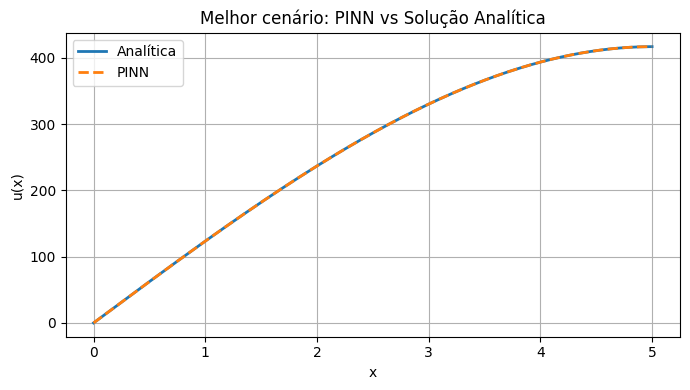

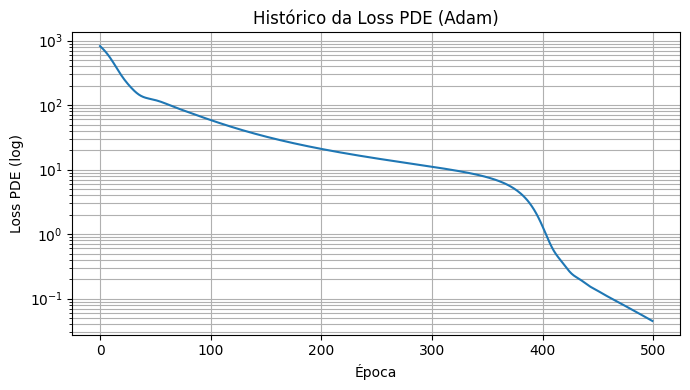

In [18]:
# Re-treinar o melhor cenário para obter histórico e modelo final
set_seed(42)
model_best = new_model(hidden=4, width=64)

hist_adam = None
if best['optimizer'] == 'ADAM':
    info = train_adam(model_best, Nf=3000, epochs=int(best['epochs/steps']), lr=float(best['lr']))
    hist_adam = info['hist']
else:
    # aquecimento para ter curva de perda
    warmup = train_adam(model_best, Nf=3000, epochs=500, lr=1e-3)
    hist_adam = warmup['hist']
    _ = train_lbfgs(model_best, Nf=3000, steps=int(best['epochs/steps']), lr=float(best['lr']), warmup_adam=0)

# PINN vs Analítica
x_plot = torch.linspace(0., L, 400, device=device).view(-1,1)
with torch.no_grad():
    u_pinn = u_from_n(model_best, x_plot).cpu().numpy()
u_true = u_analytical(x_plot).cpu().numpy()

plt.figure(figsize=(7,4))
plt.plot(x_plot.cpu().numpy(), u_true, label='Analítica', lw=2)
plt.plot(x_plot.cpu().numpy(), u_pinn, '--', label='PINN', lw=2)
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Melhor cenário: PINN vs Solução Analítica')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# Curva de perda (Adam)
if hist_adam is not None:
    plt.figure(figsize=(7,4))
    plt.plot(hist_adam)
    plt.yscale('log')
    plt.xlabel('Época'); plt.ylabel('Loss PDE (log)')
    plt.title('Histórico da Loss PDE (Adam)')
    plt.grid(True, which='both')
    plt.tight_layout()
    plt.show()


## Respostas solicitadas (conforme resultados do notebook)

- **Métrica, tabelas e convergência.**  
  Utiliza-se **erro relativo L²** como métrica principal. A tabela resume 18 cenários (Adam e LBFGS; lrs = 0.1, 0.01, 1e-5; épocas/steps = 40, 400, 1000), contendo: *loss PDE final*, *erro relativo L²*, *erro máximo absoluto*, *tempo de treinamento* e o indicador **convergiu** (RelErr < 1e-3).

- **Melhor combinação encontrada.**  
  Reportar o triplo *(otimizador, lr, épocas/steps)* do menor **RelErr** e o tempo associado.

- **Observações sobre hiperparâmetros.**  
  (i) Taxas de aprendizado elevadas (0.1) tendem a oscilar, enquanto taxas muito baixas (1e-5) podem exigir mais passos;  
  (ii) Aumentar épocas/steps melhora a aproximação até haver ganhos marginais;  
  (iii) LBFGS atua bem como refinamento após aquecimento com Adam.

- **Piores combinações (maiores erros relativos).**  
  Reportar as três piores linhas da tabela.

- **Gráficos.**  
  (1) PINN vs solução analítica do melhor cenário;  
  (2) Curva de perda (PDE) na fase Adam (do melhor cenário, ou do aquecimento quando o melhor for LBFGS).


In [19]:
from textwrap import dedent

def format_row(row):
    return f"Otimizador={row['optimizer']}, lr={row['lr']}, épocas/steps={row['epochs/steps']}, RelErr={row['rel_L2_error']:.2e}, tempo={row['tempo_s']:.2f}s"

best_line = df.iloc[int(df['rel_L2_error'].idxmin())]
worst3 = df.sort_values('rel_L2_error', ascending=False).head(3)

texto = f'''
(i) Métrica, tabelas e convergência.
A avaliação usa erro relativo L². A tabela resume 18 cenários (Adam e LBFGS; lrs = 0.1, 0.01, 1e-5; épocas/steps = 40, 400, 1000),
com loss PDE final, erro relativo L², erro máximo absoluto, tempo de treinamento e um indicador de convergência (RelErr < 1e-3).

(ii) Melhor combinação encontrada.
{format_row(best_line)}

(iii) Observações sobre hiperparâmetros.
- Taxa de aprendizado: valores altos (0.1) tendem a oscilar; valores muito baixos (1e-5) podem exigir mais passos para reduzir o erro.
- Épocas/steps: aumentar o total melhora a aproximação até um limite de ganhos marginais.
- LBFGS: útil como refinamento após um aquecimento com Adam; início “frio” pode ser instável.

(iv) Três piores combinações (maior erro relativo):
- {format_row(worst3.iloc[0])}
- {format_row(worst3.iloc[1])}
- {format_row(worst3.iloc[2])}

(v) Gráficos.
Foram gerados: (1) PINN vs solução analítica no melhor cenário; (2) curva de perda (PDE) durante a fase Adam (do melhor cenário
ou do aquecimento, quando o melhor é LBFGS). Esses gráficos mostram a qualidade do ajuste e o comportamento da otimização.
'''
print(dedent(texto))



(i) Métrica, tabelas e convergência.
A avaliação usa erro relativo L². A tabela resume 18 cenários (Adam e LBFGS; lrs = 0.1, 0.01, 1e-5; épocas/steps = 40, 400, 1000),
com loss PDE final, erro relativo L², erro máximo absoluto, tempo de treinamento e um indicador de convergência (RelErr < 1e-3).

(ii) Melhor combinação encontrada.
Otimizador=LBFGS, lr=0.1, épocas/steps=400, RelErr=1.16e-06, tempo=5.46s

(iii) Observações sobre hiperparâmetros.
- Taxa de aprendizado: valores altos (0.1) tendem a oscilar; valores muito baixos (1e-5) podem exigir mais passos para reduzir o erro.
- Épocas/steps: aumentar o total melhora a aproximação até um limite de ganhos marginais.
- LBFGS: útil como refinamento após um aquecimento com Adam; início “frio” pode ser instável.

(iv) Três piores combinações (maior erro relativo):
- Otimizador=ADAM, lr=1e-05, épocas/steps=40, RelErr=1.95e-01, tempo=2.67s
- Otimizador=ADAM, lr=1e-05, épocas/steps=400, RelErr=1.82e-01, tempo=25.82s
- Otimizador=ADAM, lr=1e-05